# PLAsTiCC Model Density Maps
### Gautham Narayan, Rafael Martinez 

Need to make density maps for each of the PLAsTiCC models

In [1]:
%matplotlib inline
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import glob
import healpy as hp
import astropy.table as at
import astropy.io.fits as afits
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
import astropy.visualization as aviz
import progressbar
import matplotlib.cm as cm

cmap = cm.gray
cmap.set_bad('grey')
cmap.set_under('white')
cmap2 = cm.inferno
cmap2.set_bad('grey')
cmap2.set_under('white')

plt.rcParams['figure.figsize'] = [7, 7]

NSIDE = 32

### Define a big function to interpolate healpix maps from the RA Dec Tables



In [3]:
def map_from_arrays(l, b, obj, model_name, pix_2_coord_dict=None,\
                 interp=True, interp_min=0., verbose=False, overwrite=False, NSIDE=32):
    """
    Build a Healpix map from some arrays, l, b, objname
    
    This is a fairly involved function - loads map and returns if it exists, else will generate from scratch
    Optionally interpolates missing pixels that are surrounded by at least 5 (hardcoded) good neighbors
    Returns a map, a dictionary of mapping from coordinate to Healpix pixel, and the NSIDE of the map (32 by default)
    The dictionary mapping can be reused on subsequent calls to generate more maps from the same CSV
    """
   
    DEFAULT_NSIDE = 32
    if NSIDE < 8:
        NSIDE = DEFAULT_NSIDE
    # this is a tradeoff effectively set by native map resolution vs LSST Simlib pointing resolution
    # the higher we raise this, the higher the resolution of the Healpix map
    # but the more NaN pixels that can't be interpolated over
    # we just need to make it large enough that each HEALpix Pixel covers at least one Simlib pointing

    filename = '{}.fits'.format(model_name)
    if os.path.exists(filename) and not overwrite:
        try:
            mapdata = hp.fitsfunc.read_map(filename, h=False, verbose=True)       
            return mapdata, {}, NSIDE
        except Exception as e:
            pass
    print("Rendering {} map".format(model_name))                
    npix = hp.nside2npix(NSIDE)
    newmap = np.zeros(npix, dtype=np.float32)
    array_inds = np.arange(npix)
    newmap[:] = np.nan
        
    # if we know the mapping between 1-D pixel and position on the sky, then we can just restore that
    # Since Rahul has a fixed set of Simlib positions, this should rapidly become populated
    if pix_2_coord_dict is None:
        theta = l
        phi   = b
        pix_2_coord_dict = {}
        pix_coord = hp.pixelfunc.ang2pix(NSIDE, theta, phi, nest=False, lonlat=True)
        nmax = len(pix_coord)
    else:
        pix_coord = pix_2_coord_dict.keys()
        nmax = len(pix_coord)
        if nmax == 0:
            theta = l
            phi   = b
            pix_coord = hp.pixelfunc.ang2pix(NSIDE, theta, phi, nest=False, lonlat=True)
        
        
    # this keeps a track of if we considered this pixel for the map
    # since multiple positions can map to the same coordinate (and do, particularly near the pole)
    used_coord = {}
    
    nmax = len(pix_coord)
    bar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=nmax).start()
    for i, coord in enumerate(pix_coord):
        # skip pixels we've already set
        if coord in used_coord:
            continue
        
        # if we have the mapping from pixel to coordinate
        # then just restore the indices of coordinates that contribute to this pixel
        ind = pix_2_coord_dict.get(coord, None)
        if ind is None:
            ind = np.where(pix_coord == coord)[0]
        
        # we're just making a hit map so just need the length
        newmap[coord] = len(obj[ind])
        pix_2_coord_dict[coord] = ind
        used_coord[coord] = 1
        bar.update(i+1)
    
    # what was the extent of the data we set
    used_coord = np.array(used_coord.keys())
    min_pix = used_coord.min()
    max_pix = used_coord.max()
    
    bad_ind = newmap < interp_min
    newmap[bad_ind] = np.nan
    
    # if we aren't interpolating, just save and return
    if not interp:
        # write this map to a file so we can restore in future without recomputing
        try:
            hp.fitsfunc.write_map(filename, newmap, nest=False, coord='G',\
                          partial=False, fits_IDL=False,\
                          column_names=['num',], overwrite=True)
        except Exception as e:
            print("{}".format(e))
            pass
        return newmap, pix_2_coord_dict, NSIDE

    # attempt to interpolate bad pixels using any neighboring good pixels
    nan_coords = ~np.isfinite(newmap)
    newmap[nan_coords] = hp.pixelfunc.UNSEEN

    print('INTERPOLATING')
    # what are the bad coordinates *within the range of the coordinates we considered*
    bad_coords = np.where((nan_coords) & (array_inds > min_pix) & (array_inds < max_pix))[0]
    ctr = 0
    use_pix = []
    use_val = []
    for coord in bad_coords:
        theta, phi = hp.pixelfunc.pix2ang(NSIDE, coord, nest=False, lonlat=True)
        interp_pix = hp.pixelfunc.get_all_neighbours(NSIDE, theta, phi, nest=False, lonlat=True)
        ind = interp_pix != -1
        interp_pix = interp_pix[ind]
        pix_val    = newmap[interp_pix]
        good_pix   = pix_val != hp.pixelfunc.UNSEEN
        ngood = len(pix_val[good_pix])
        # there's 8 neighbors, total, but some may have no neighbor (-1) or be set to UNSEEN themselves.
        # require at least 5 for interpolation. If not give up.
        if ngood >= 5:      
            interp_val = np.mean(pix_val[good_pix])
        else:
            interp_val = hp.pixelfunc.UNSEEN
        if verbose and ctr < 10: 
            print(coord, interp_val)
            ctr+=1       
        if interp_val != hp.pixelfunc.UNSEEN:
            if interp_val < interp_min:
                interp_val = interp_min
        # save the interpolated value and coordinate
        # do not set it inside the loop
        # we don't want to use interpolated values themselves for further interpolation
        use_pix.append(coord)
        use_val.append(interp_val)
        
    use_pix = np.array(use_pix)
    use_val = np.array(use_val)
    newmap[use_pix] = use_val
    
    stillbad_ind = np.where(newmap == hp.pixelfunc.UNSEEN)
    newmap[stillbad_ind] = np.nan
    
    # write this map to a file so we can restore in future without recomputing
    try:
        hp.fitsfunc.write_map(filename, newmap, nest=False, coord='G', partial=False, fits_IDL=False,\
                          column_names=['num',], overwrite=True)
    except Exception as e:
        print("{}".format(e))
        pass
    
    return newmap, pix_2_coord_dict, NSIDE
 

In [4]:
indata = at.Table.read('MODEL01.dat', format='ascii')

In [5]:
coord = SkyCoord(indata['ra'], indata['decl'], unit=(u.degree, u.degree))

In [6]:
l = coord.galactic.l.value
b = coord.galactic.b.value

In [7]:
pix_2_coord_dict = {}
model01, pix_2_coord_dict, NSIDE = map_from_arrays(l, b, indata['objid'], 'MODEL01',\
                          pix_2_coord_dict = pix_2_coord_dict, interp=False, overwrite=False, NSIDE=16)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/gnarayan/anaconda3/envs/SNspec/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


/Users/gnarayan/anaconda3/envs/SNspec/lib/python2.7/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/gnarayan/anaconda3/envs/SNspec/lib/python2.7/site-packages/healpy/projaxes.py:859: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[np.isinf(val.data)] = -np.inf


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


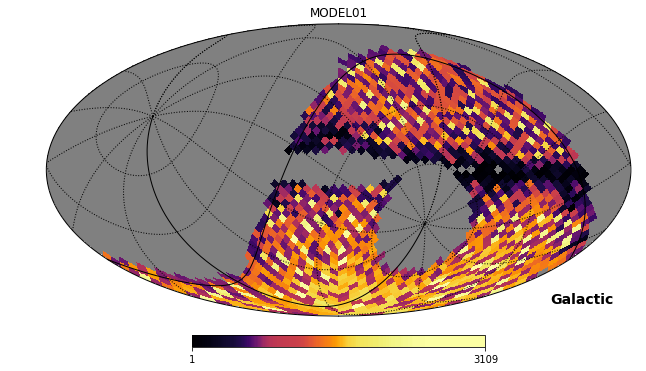

In [8]:
hp.mollview(model01, coord=['G',], norm='hist', title='MODEL01', cmap=cmap2)
hp.graticule(coord=['C'])

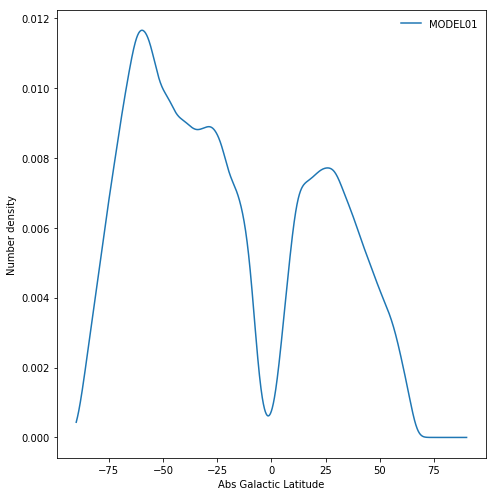

In [9]:
from scipy.stats import gaussian_kde
b_range = np.arange(-90, 90.1, 0.1)
density = gaussian_kde(b, bw_method='scott')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(b_range, density(b_range), label='MODEL01')
ax.legend(frameon=False)
ax.set_xlabel('Abs Galactic Latitude')
ax.set_ylabel('Number density')
fig.tight_layout()